In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install tensorpack

%cd gdrive/MyDrive/SEAI_Project

     |████████████████████████████████| 296 kB 7.8 MB/s 
/content/gdrive/MyDrive/SEAI_Project


In [10]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# File: svhn-digit-dorefa.py
# Author: Yuxin Wu

import argparse
import os
import tensorflow as tf

from tensorpack import *
from tensorpack.dataflow import dataset
from tensorpack.tfutils.summary import add_moving_summary, add_param_summary
from tensorpack.tfutils.varreplace import remap_variables

"""
This is a tensorpack script for the SVHN results in paper:
DoReFa-Net: Training Low Bitwidth Convolutional Neural Networks with Low Bitwidth Gradients
http://arxiv.org/abs/1606.06160
The original experiements are performed on a proprietary framework.
This is our attempt to reproduce it on tensorpack.
Accuracy:
    With (W,A,G)=(1,1,4), can reach 3.1~3.2% error after 150 epochs.
    With (W,A,G)=(1,2,4), error is 3.0~3.1%.
    With (W,A,G)=(32,32,32), error is about 2.3%.
Speed:
    With quantization, 60 batch/s on 1 1080Ti. (4721 batch / epoch)
To Run:
    ./svhn-digit-dorefa.py --dorefa 1,2,4
"""
tf.compat.v1.reset_default_graph()

BITW = 6
BITA = 4
BITG = 4

"""
imported from dorefa file
"""
def get_dorefa(bitW, bitA, bitG):
    """
    Return the three quantization functions fw, fa, fg, for weights, activations and gradients respectively
    """
    def quantize(x, k):
        n = float(2 ** k - 1)

        @tf.custom_gradient
        def _quantize(x):
            return tf.round(x * n) / n, lambda dy: dy

        return _quantize(x)

    def fw(x):
        if bitW == 32:
            return x

        if bitW == 1:   # BWN
            E = tf.stop_gradient(tf.reduce_mean(tf.abs(x)))

            @tf.custom_gradient
            def _sign(x):
                return tf.where(tf.equal(x, 0), tf.ones_like(x), tf.sign(x / E)) * E, lambda dy: dy

            return _sign(x)

        x = tf.tanh(x)
        x = x / tf.reduce_max(tf.abs(x)) * 0.5 + 0.5
        return 2 * quantize(x, bitW) - 1

    def fa(x):
        if bitA == 32:
            return x
        return quantize(x, bitA)

    def fg(x):
        if bitG == 32:
            return x

        @tf.custom_gradient
        def _identity(input):
            def grad_fg(x):
                rank = x.get_shape().ndims
                assert rank is not None
                maxx = tf.reduce_max(tf.abs(x), list(range(1, rank)), keepdims=True)
                x = x / maxx
                n = float(2**bitG - 1)
                x = x * 0.5 + 0.5 + tf.random.uniform(
                    tf.shape(x), minval=-0.5 / n, maxval=0.5 / n)
                x = tf.clip_by_value(x, 0.0, 1.0)
                x = quantize(x, bitG) - 0.5
                return x * maxx * 2

            return input, grad_fg

        return _identity(x)
    return fw, fa, fg


class Model(ModelDesc):
    def inputs(self):
        return [tf.TensorSpec([None, 40, 40], tf.float32, 'input'),
                tf.TensorSpec([None], tf.int32, 'label')]

    def build_graph(self, image, label):
        fw, fa, fg = get_dorefa(BITW, BITA, BITG)

        # monkey-patch tf.get_variable to apply fw
        def binarize_weight(v):
            name = v.op.name
            # don't binarize first and last layer
            
            if not name.endswith('W'):
                return v
            else:
                logger.info("Binarizing weight {}".format(v.op.name))
                return fw(v)

        def nonlin(x):
            if BITA == 32:
                return tf.nn.relu(x)
            return tf.clip_by_value(x, 0.0, 1.0)

        def activate(x):
            return fa(nonlin(x))

        image = tf.expand_dims(image, 3)
        image = image / 256.0

        with remap_variables(binarize_weight), \
                argscope(BatchNorm, momentum=0.9, epsilon=1e-4), \
                argscope(Conv2D, use_bias=False):
            logits = (LinearWrap(image)
                      .Conv2D('conv0', 48, 5, padding='VALID', use_bias=True)
                      .AvgPooling('pool0', 2, padding='SAME')
                      .apply(activate)
                      # 18
                      .Conv2D('conv1', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn1').apply(activate)
#AVGPooling
                      .Conv2D('conv2', 64, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn2')
                      .AvgPooling('pool1', 2, padding='SAME')
                      .apply(activate)
                      # 9
                      .Conv2D('conv3', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn3').apply(activate)
                      # 7

                      .Conv2D('conv4', 128, 3, padding='SAME')
                      .apply(fg)
                      .BatchNorm('bn4').apply(activate)

                      .Conv2D('conv5', 128, 3, padding='VALID')
                      .apply(fg)
                      .BatchNorm('bn5').apply(activate)
                      # 5
                      .Dropout(rate=0.5 if self.training else 0.0)
                      .Conv2D('conv6', 512, 5, padding='VALID')
                      .apply(fg).BatchNorm('bn6')
                      .apply(nonlin)
                      .FullyConnected('fc1', 10)())
        tf.nn.softmax(logits, name='output')

        correct = tf.cast(tf.nn.in_top_k(predictions=logits, targets=label, k=1), tf.float32, name='correct')
        accuracy = tf.reduce_mean(correct, name='accuracy')
        train_error = tf.reduce_mean(1 - correct, name='train_error')
        summary.add_moving_summary(train_error, accuracy)
        
        cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
        cost = tf.reduce_mean(cost, name='cross_entropy_loss')
        # weight decay on all W of fc layers
        wd_cost = regularize_cost('fc.*/W', l2_regularizer(1e-7))
        add_param_summary(('.*/W', ['histogram', 'rms']))
        total_cost = tf.add_n([cost, wd_cost], name='cost')
        add_moving_summary(cost, wd_cost, total_cost)
        return total_cost

    def optimizer(self):
        lr = tf.compat.v1.train.exponential_decay(
            learning_rate=1e-3,
            global_step=get_global_step_var(),
            decay_steps=4721 * 100,
            decay_rate=0.5, staircase=True, name='learning_rate')
        tf.summary.scalar('lr', lr)

        return tf.compat.v1.train.AdamOptimizer(lr, epsilon=1e-5)


def get_config():
    logger.set_logger_dir(os.path.join('train_log', 'mnist-dorefa-{}'.format(args)))

    # prepare dataset
    data_train = dataset.Mnist('train', shuffle=True)
    data_test = dataset.Mnist('test', shuffle=True)

    augmentors = [imgaug.Resize((40, 40))]
    data_train = AugmentImageComponent(data_train, augmentors)
    data_train = BatchData(data_train, 128)
    data_train = MultiProcessRunnerZMQ(data_train, 5)

    augmentors = [imgaug.Resize((40, 40))]
    data_test = AugmentImageComponent(data_test, augmentors)
    data_test = BatchData(data_test, 128, remainder=True)

    return TrainConfig(
        data=QueueInput(data_train),
        callbacks=[
            ModelSaver(),
            InferenceRunner(    # run inference(for validation) after every epoch
                data_test,   # the DataFlow instance used for validation
                ScalarStats(    # produce `val_accuracy` and `val_cross_entropy_loss`
                    ['cross_entropy_loss', 'accuracy'], prefix='val'))
        ],
        model=Model(),
        max_epoch=10,
    )

args = "6,4,4"
BITW, BITA, BITG = map(int, args.split(','))
config = get_config()
launch_train_with_config(config, SimpleTrainer())

'''
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--dorefa',
                        help='number of bits for W,A,G, separated by comma. Defaults to \'1,2,4\'',
                        default='1,2,4')
    args = parser.parse_args()

    BITW, BITA, BITG = map(int, args.dorefa.split(','))
    config = get_config()
    launch_train_with_config(config, SimpleTrainer())
'''

[0721 21:34:51 @logger.py:128] WRN Log directory train_log/mnist-dorefa-6,4,4 exists! Use 'd' to delete it. 
[0721 21:34:51 @logger.py:131] WRN If you're resuming from a previous run, you can choose to keep it.
Press any other key to exit. 
Select Action: k (keep) / d (delete) / q (quit):k
[0721 21:34:53 @logger.py:85] Existing log file 'train_log/mnist-dorefa-6,4,4/log.log' backuped to 'train_log/mnist-dorefa-6,4,4/log.log.0721-213453'
[0721 21:34:53 @logger.py:92] Argv: /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-b5b3c3e8-7cd5-4670-bbd6-bf8d3ba9e586.json
[0721 21:34:53 @parallel.py:340] [MultiProcessRunnerZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0721 21:34:53 @input_source.py:221] Setting up the queue 'QueueInput/input_queue' for CPU prefetching ...
[0721 21:34:53 @trainers.py:48] Building graph for a single training tower ...
[0721 21:34:53 @<ipython-input-10-1b6bc8653604>:114

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[0721 21:34:53 @<ipython-input-10-1b6bc8653604>:114] Binarizing weight conv5/W
[0721 21:34:54 @<ipython-input-10-1b6bc8653604>:114] Binarizing weight conv6/W
[0721 21:34:54 @<ipython-input-10-1b6bc8653604>:114] Binarizing weight fc1/W
[0721 21:34:54 @regularize.py:97] regularize_cost() found 1 variables to regularize.
[0721 21:34:54 @regularize.py:21] The following tensors will be regularized: fc1/W:0
[0721 21:34:54 @model_utils.py:67] List of Trainable Variables: 
name       shape               #elements
---------  ----------------  -----------
conv0/W    [5, 5, 1, 48]            1200
conv0/b    [48]                       48
conv1/W    [3, 3, 48, 64]          27648
bn1/gamma  [64]                       64
bn1/beta   [64]                       64
conv2/W    [3, 3, 64, 64]          36864
bn2/gamma  [64]                       64
bn2/beta   [64]                       64
conv3/W    [3, 3, 64, 128]         73728
bn3/gamma  [128]                     128
bn3/beta   [128]                     1

100%|##########|468/468[00:13<00:00,34.04it/s]

[0721 21:35:12 @base.py:283] Epoch 1 (global_step 468) finished, time:13.8 seconds.
[0721 21:35:12 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-468.



100%|##########|79/79[00:01<00:00,78.54it/s]

[0721 21:35:13 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:35:13 @monitor.py:476] accuracy: 0.090833
[0721 21:35:13 @monitor.py:476] cost: 2.451
[0721 21:35:13 @monitor.py:476] cross_entropy_loss: 2.451
[0721 21:35:13 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:35:13 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:35:13 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:35:13 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:35:13 @monitor.py:476] param-summary/conv4/W-rms: 0.041798
[0721 21:35:13 @monitor.py:476] param-summary/conv5/W-rms: 0.045588
[0721 21:35:13 @monitor.py:476] param-summary/conv6/W-rms: 0.03052
[0721 21:35:13 @monitor.py:476] param-summary/fc1/W-rms: 0.032046
[0721 21:35:13 @monitor.py:476] regularize_cost: 2.7436e-07
[0721 21:35:13 @monitor.py:476] train_error: 0.90917
[0721 21:35:13 @monitor.py:476] val_accuracy: 0.11501
[0721 21:35:13 @monitor.py:476] val_cross_entropy_loss: 2.3708
[0721 21:35:13 @base


100%|##########|468/468[00:12<00:00,36.68it/s]

[0721 21:35:26 @base.py:283] Epoch 2 (global_step 936) finished, time:12.8 seconds.
[0721 21:35:26 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-936.



100%|##########|79/79[00:00<00:00,89.17it/s]

[0721 21:35:27 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:35:27 @monitor.py:476] accuracy: 0.10038
[0721 21:35:27 @monitor.py:476] cost: 2.3511
[0721 21:35:27 @monitor.py:476] cross_entropy_loss: 2.3511
[0721 21:35:27 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:35:27 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:35:27 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:35:27 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:35:27 @monitor.py:476] param-summary/conv4/W-rms: 0.041799
[0721 21:35:27 @monitor.py:476] param-summary/conv5/W-rms: 0.046491
[0721 21:35:27 @monitor.py:476] param-summary/conv6/W-rms: 0.031856
[0721 21:35:27 @monitor.py:476] param-summary/fc1/W-rms: 0.025205
[0721 21:35:27 @monitor.py:476] regularize_cost: 1.6427e-07
[0721 21:35:27 @monitor.py:476] train_error: 0.89962
[0721 21:35:27 @monitor.py:476] val_accuracy: 0.096915
[0721 21:35:27 @monitor.py:476] val_cross_entropy_loss: 2.3041
[0721 21:35:27 @b


100%|##########|468/468[00:12<00:00,36.44it/s]

[0721 21:35:40 @base.py:283] Epoch 3 (global_step 1404) finished, time:12.8 seconds.
[0721 21:35:40 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-1404.



100%|##########|79/79[00:00<00:00,87.80it/s]

[0721 21:35:41 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:35:41 @monitor.py:476] accuracy: 0.099787
[0721 21:35:41 @monitor.py:476] cost: 2.3346
[0721 21:35:41 @monitor.py:476] cross_entropy_loss: 2.3346
[0721 21:35:41 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:35:41 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:35:41 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:35:41 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:35:41 @monitor.py:476] param-summary/conv4/W-rms: 0.041801
[0721 21:35:41 @monitor.py:476] param-summary/conv5/W-rms: 0.04704
[0721 21:35:41 @monitor.py:476] param-summary/conv6/W-rms: 0.032849
[0721 21:35:41 @monitor.py:476] param-summary/fc1/W-rms: 0.023946
[0721 21:35:41 @monitor.py:476] regularize_cost: 1.4713e-07
[0721 21:35:41 @monitor.py:476] train_error: 0.90021
[0721 21:35:41 @monitor.py:476] val_accuracy: 0.11363
[0721 21:35:41 @monitor.py:476] val_cross_entropy_loss: 2.3037
[0721 21:35:41 @ba


100%|##########|468/468[00:12<00:00,36.98it/s]

[0721 21:35:54 @base.py:283] Epoch 4 (global_step 1872) finished, time:12.7 seconds.
[0721 21:35:54 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-1872.



100%|##########|79/79[00:00<00:00,90.07it/s]

[0721 21:35:55 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:35:55 @monitor.py:476] accuracy: 0.10047
[0721 21:35:55 @monitor.py:476] cost: 2.3296
[0721 21:35:55 @monitor.py:476] cross_entropy_loss: 2.3296
[0721 21:35:55 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:35:55 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:35:55 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:35:55 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:35:55 @monitor.py:476] param-summary/conv4/W-rms: 0.041801
[0721 21:35:55 @monitor.py:476] param-summary/conv5/W-rms: 0.047426
[0721 21:35:55 @monitor.py:476] param-summary/conv6/W-rms: 0.033999
[0721 21:35:55 @monitor.py:476] param-summary/fc1/W-rms: 0.023983
[0721 21:35:55 @monitor.py:476] regularize_cost: 1.4713e-07
[0721 21:35:55 @monitor.py:476] train_error: 0.89953
[0721 21:35:55 @monitor.py:476] val_accuracy: 0.099782
[0721 21:35:55 @monitor.py:476] val_cross_entropy_loss: 2.3031
[0721 21:35:55 @b


100%|##########|468/468[00:12<00:00,36.49it/s]

[0721 21:36:07 @base.py:283] Epoch 5 (global_step 2340) finished, time:12.8 seconds.
[0721 21:36:08 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-2340.



100%|##########|79/79[00:00<00:00,86.41it/s]

[0721 21:36:09 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:36:09 @monitor.py:476] accuracy: 0.10655
[0721 21:36:09 @monitor.py:476] cost: 2.326
[0721 21:36:09 @monitor.py:476] cross_entropy_loss: 2.326
[0721 21:36:09 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:36:09 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:36:09 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:36:09 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:36:09 @monitor.py:476] param-summary/conv4/W-rms: 0.041804
[0721 21:36:09 @monitor.py:476] param-summary/conv5/W-rms: 0.048012
[0721 21:36:09 @monitor.py:476] param-summary/conv6/W-rms: 0.035312
[0721 21:36:09 @monitor.py:476] param-summary/fc1/W-rms: 0.024158
[0721 21:36:09 @monitor.py:476] regularize_cost: 1.4938e-07
[0721 21:36:09 @monitor.py:476] train_error: 0.89345
[0721 21:36:09 @monitor.py:476] val_accuracy: 0.11501
[0721 21:36:09 @monitor.py:476] val_cross_entropy_loss: 2.3024
[0721 21:36:09 @base


100%|##########|468/468[00:12<00:00,37.08it/s]

[0721 21:36:21 @base.py:283] Epoch 6 (global_step 2808) finished, time:12.6 seconds.
[0721 21:36:21 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-2808.



100%|##########|79/79[00:00<00:00,83.20it/s]

[0721 21:36:22 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:36:22 @monitor.py:476] accuracy: 0.10293
[0721 21:36:22 @monitor.py:476] cost: 2.3247
[0721 21:36:22 @monitor.py:476] cross_entropy_loss: 2.3247
[0721 21:36:22 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:36:22 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:36:22 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:36:22 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:36:22 @monitor.py:476] param-summary/conv4/W-rms: 0.041807
[0721 21:36:22 @monitor.py:476] param-summary/conv5/W-rms: 0.048796
[0721 21:36:22 @monitor.py:476] param-summary/conv6/W-rms: 0.036485
[0721 21:36:22 @monitor.py:476] param-summary/fc1/W-rms: 0.024488
[0721 21:36:22 @monitor.py:476] regularize_cost: 1.5334e-07
[0721 21:36:22 @monitor.py:476] train_error: 0.89707
[0721 21:36:22 @monitor.py:476] val_accuracy: 0.11363
[0721 21:36:22 @monitor.py:476] val_cross_entropy_loss: 2.3019
[0721 21:36:22 @ba


100%|##########|468/468[00:12<00:00,36.75it/s]

[0721 21:36:35 @base.py:283] Epoch 7 (global_step 3276) finished, time:12.7 seconds.
[0721 21:36:35 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-3276.



100%|##########|79/79[00:00<00:00,85.66it/s]

[0721 21:36:36 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:36:36 @monitor.py:476] accuracy: 0.097057
[0721 21:36:36 @monitor.py:476] cost: 2.3253
[0721 21:36:36 @monitor.py:476] cross_entropy_loss: 2.3253
[0721 21:36:36 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:36:36 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:36:36 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:36:36 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:36:36 @monitor.py:476] param-summary/conv4/W-rms: 0.041815
[0721 21:36:36 @monitor.py:476] param-summary/conv5/W-rms: 0.050164
[0721 21:36:36 @monitor.py:476] param-summary/conv6/W-rms: 0.038179
[0721 21:36:36 @monitor.py:476] param-summary/fc1/W-rms: 0.024746
[0721 21:36:36 @monitor.py:476] regularize_cost: 1.5667e-07
[0721 21:36:36 @monitor.py:476] train_error: 0.90294
[0721 21:36:36 @monitor.py:476] val_accuracy: 0.099881
[0721 21:36:36 @monitor.py:476] val_cross_entropy_loss: 2.3027
[0721 21:36:36 @


100%|##########|468/468[00:12<00:00,36.43it/s]

[0721 21:36:49 @base.py:283] Epoch 8 (global_step 3744) finished, time:12.9 seconds.
[0721 21:36:49 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-3744.



100%|##########|79/79[00:00<00:00,86.97it/s]

[0721 21:36:50 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:36:50 @monitor.py:476] accuracy: 0.10254
[0721 21:36:50 @monitor.py:476] cost: 2.3186
[0721 21:36:50 @monitor.py:476] cross_entropy_loss: 2.3186
[0721 21:36:50 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:36:50 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:36:50 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:36:50 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:36:50 @monitor.py:476] param-summary/conv4/W-rms: 0.041822
[0721 21:36:50 @monitor.py:476] param-summary/conv5/W-rms: 0.051481
[0721 21:36:50 @monitor.py:476] param-summary/conv6/W-rms: 0.040293
[0721 21:36:50 @monitor.py:476] param-summary/fc1/W-rms: 0.025141
[0721 21:36:50 @monitor.py:476] regularize_cost: 1.6184e-07
[0721 21:36:50 @monitor.py:476] train_error: 0.89746
[0721 21:36:50 @monitor.py:476] val_accuracy: 0.096915
[0721 21:36:50 @monitor.py:476] val_cross_entropy_loss: 2.3027
[0721 21:36:50 @b


100%|##########|468/468[00:13<00:00,35.86it/s]

[0721 21:37:03 @base.py:283] Epoch 9 (global_step 4212) finished, time:13.1 seconds.
[0721 21:37:03 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-4212.



100%|##########|79/79[00:00<00:00,90.33it/s]

[0721 21:37:04 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:37:04 @monitor.py:476] accuracy: 0.1089
[0721 21:37:04 @monitor.py:476] cost: 2.3203
[0721 21:37:04 @monitor.py:476] cross_entropy_loss: 2.3203
[0721 21:37:04 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:37:04 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:37:04 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:37:04 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:37:04 @monitor.py:476] param-summary/conv4/W-rms: 0.04183
[0721 21:37:04 @monitor.py:476] param-summary/conv5/W-rms: 0.052907
[0721 21:37:04 @monitor.py:476] param-summary/conv6/W-rms: 0.042358
[0721 21:37:04 @monitor.py:476] param-summary/fc1/W-rms: 0.025457
[0721 21:37:04 @monitor.py:476] regularize_cost: 1.6581e-07
[0721 21:37:04 @monitor.py:476] train_error: 0.8911
[0721 21:37:04 @monitor.py:476] val_accuracy: 0.097607
[0721 21:37:04 @monitor.py:476] val_cross_entropy_loss: 2.3022
[0721 21:37:04 @base


100%|##########|468/468[00:12<00:00,37.39it/s]

[0721 21:37:17 @base.py:283] Epoch 10 (global_step 4680) finished, time:12.5 seconds.
[0721 21:37:17 @saver.py:82] Model saved to train_log/mnist-dorefa-6,4,4/model-4680.



100%|##########|79/79[00:00<00:00,88.45it/s]

[0721 21:37:18 @monitor.py:476] QueueInput/queue_size: 50
[0721 21:37:18 @monitor.py:476] accuracy: 0.10229
[0721 21:37:18 @monitor.py:476] cost: 2.3112
[0721 21:37:18 @monitor.py:476] cross_entropy_loss: 2.3112
[0721 21:37:18 @monitor.py:476] param-summary/conv0/W-rms: 0.29912
[0721 21:37:18 @monitor.py:476] param-summary/conv1/W-rms: 0.068355
[0721 21:37:18 @monitor.py:476] param-summary/conv2/W-rms: 0.059003
[0721 21:37:18 @monitor.py:476] param-summary/conv3/W-rms: 0.05889
[0721 21:37:18 @monitor.py:476] param-summary/conv4/W-rms: 0.04183
[0721 21:37:18 @monitor.py:476] param-summary/conv5/W-rms: 0.054214
[0721 21:37:18 @monitor.py:476] param-summary/conv6/W-rms: 0.044284
[0721 21:37:18 @monitor.py:476] param-summary/fc1/W-rms: 0.025887
[0721 21:37:18 @monitor.py:476] regularize_cost: 1.7115e-07
[0721 21:37:18 @monitor.py:476] train_error: 0.89771
[0721 21:37:18 @monitor.py:476] val_accuracy: 0.11294
[0721 21:37:18 @monitor.py:476] val_cross_entropy_loss: 2.3017
[0721 21:37:18 @bas

"\nif __name__ == '__main__':\n    parser = argparse.ArgumentParser()\n    parser.add_argument('--dorefa',\n                        help='number of bits for W,A,G, separated by comma. Defaults to '1,2,4'',\n                        default='1,2,4')\n    args = parser.parse_args()\n\n    BITW, BITA, BITG = map(int, args.dorefa.split(','))\n    config = get_config()\n    launch_train_with_config(config, SimpleTrainer())\n"

<Figure size 432x288 with 0 Axes>

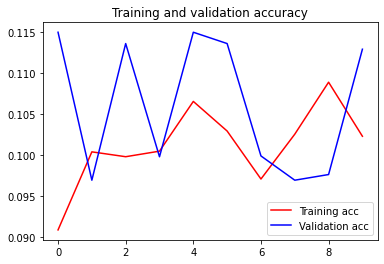

<Figure size 432x288 with 0 Axes>

In [11]:
import json
import matplotlib.pyplot as plt

f = open("train_log/mnist-dorefa-6,4,4/stats.json","r")

data = json.load(f)
accuracy = []
val_accuracy = []
for ob in data:
  accuracy.append(ob["accuracy"])
  val_accuracy.append(ob["val_accuracy"])

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [12]:
from tabulate import tabulate
import matplotlib.pyplot as plt

ep = [i+1 for i in epochs]
table_acc = {"Epochs" : ep, "Accuracy":accuracy}
table_val_acc = {"Epochs" : ep, "Accuracy":val_accuracy}

print("ACCURACY\n")
print(tabulate(table_acc, headers='keys', tablefmt='fancy_grid'))
print("\nVALIDATION ACCURACY\n")
print(tabulate(table_val_acc, headers='keys', tablefmt='fancy_grid'))

ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │  0.0908328 │
├──────────┼────────────┤
│        2 │  0.100381  │
├──────────┼────────────┤
│        3 │  0.0997866 │
├──────────┼────────────┤
│        4 │  0.100466  │
├──────────┼────────────┤
│        5 │  0.106551  │
├──────────┼────────────┤
│        6 │  0.102927  │
├──────────┼────────────┤
│        7 │  0.0970573 │
├──────────┼────────────┤
│        8 │  0.102542  │
├──────────┼────────────┤
│        9 │  0.108902  │
├──────────┼────────────┤
│       10 │  0.10229   │
╘══════════╧════════════╛

VALIDATION ACCURACY

╒══════════╤════════════╕
│   Epochs │   Accuracy │
╞══════════╪════════════╡
│        1 │  0.115012  │
├──────────┼────────────┤
│        2 │  0.0969146 │
├──────────┼────────────┤
│        3 │  0.113627  │
├──────────┼────────────┤
│        4 │  0.0997824 │
├──────────┼────────────┤
│        5 │  0.115012  │
├──────────┼────────────┤
│        6 │  0.113627  │
├─────